In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [105]:
data = pd.read_csv("train.csv").to_numpy()

In [106]:
np.random.shuffle(data)
size, fan_in = data.shape
fan_in -= 1
train, test = data[:int(size*0.8)], data[int(size*0.8):]
X_train, Y_train = train.T[1:], train.T[0].reshape(-1, 1)
X_test, Y_test = test.T[1:], test.T[0].reshape(-1, 1)
output_size = len(np.unique(Y_train))

high = np.max(data)
X_train = X_train / high # normalizing data  255 -> 1
X_test = X_test /  high 

In [107]:
def one_hot(a):
    classes = a.max()
    b = np.zeros((a.size, classes + 1))
    b[np.arange(a.size), a] = 1
    return b

def get_predictions(pred):
    out = np.argmax(pred, axis=1)
    return out

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [108]:

class Linear:
    def __init__(self, fan_in, fan_out, momentum=0.9, decay_rate=0.9):
        self.weight = np.random.rand(fan_in, fan_out) / fan_in**0.5
        self.bias = np.random.rand(1, fan_out) * 0.1
        self.params = [self.weight, self.bias]
        self.momentum = momentum
        self.decay_rate = decay_rate
        self.grad_squared = [np.zeros_like(param) for param in self.params]
        self.velocity = [np.zeros_like(param) for param in self.params]
    
    def __call__(self, X):
        self.out = np.dot(X, self.weight) + self.bias
        self.input = X
        return self.out
    
    def backward(self, chain, lr):
        grad = np.dot(chain, self.weight.T)

        dw = (np.dot(self.input.T, chain))
        self.velocity[0] = self.velocity[0] * self.momentum + (1-self.momentum) * dw # momentum
        self.grad_squared[0] = self.grad_squared[0] * self.decay_rate + (1 - self.decay_rate) * dw * dw
        self.weight -= lr * self.velocity[0] / (self.grad_squared[0]**0.5 + 1e-7) 

        db = np.sum(chain, 0, keepdims=True)
        self.velocity[1] = self.velocity[1] * self.momentum + (1-self.momentum) * db # momentum
        self.grad_squared[1] = self.grad_squared[1] * self.decay_rate + (1 - self.decay_rate) * db * db
        self.bias -= lr * self.velocity[1] / (self.grad_squared[1]**0.5 + 1e-7) 
        return grad  
    
    def parameters(self):
        return [self.weight, self.bias]

class Tanh:
    def __call__(self, X):
        self.out = np.tanh(X)
        self.input = X
        return self.out 
    
    def backward(self, chain, lr):
        self.grad =  (1 - self.out**2) * chain
        return self.grad
    
class Sigmoid:
    def __call__(self, X):
        self.out = 1 / (1 + np.exp(-X))
        self.input = X
        return self.out 
        
    def backward(self, chain, lr):
        self.grad =  self.out * (1 - self.out) * chain
        return self.grad
         

class ReLU:
    def __call__(self, X):
        self.out = np.maximum(X, 0)
        self.input = X
        return self.out 
        
    def backward(self, chain, lr):
        self.grad =  (self.input > 0) * chain
        return self.grad

In [109]:
def cross_entropy(pred, real, epsilon=1e-12):
    pred = np.exp(pred - np.max(pred, axis=1, keepdims=True))
    pred /= np.sum(pred, axis=1, keepdims=True)
    
    pred = np.clip(pred, epsilon, 1 - epsilon)
    loss = -np.sum(real * np.log(pred)) / real.shape[0]
    grad = (pred - real) / real.shape[0]
    
    return loss, grad

In [110]:
n_hidden = 100
n = X_train.shape[1]

X = X_train.T
Y = Y_train

layers = [
    Linear(fan_in, n_hidden), ReLU(), 
    Linear(n_hidden, n_hidden), ReLU(),
    Linear(n_hidden, output_size),
]

lossi = []

In [111]:
def get_performance(X, Y):  # run for test
    one_hot_Y = one_hot(Y.reshape(-1, ))

    x = X
    for layer in layers:
        x = layer(x)
    x = softmax(x.T).T
    pred = get_predictions(x)
    correct = (pred == get_predictions(one_hot_Y))

    return np.count_nonzero(correct) / Y.shape[0]

In [ ]:
iters = 10000
batch_size = 100
Y_one_hot = one_hot(Y_train.reshape(-1, )) # encode labels into one-hot vectors

for iter in range(iters):
    batch = np.random.randint(0, n - batch_size) 
    Xb = X[batch:batch_size+batch] # convert input into batches
    Yb = Y_one_hot[batch:batch_size+batch] # convert output into coresponding batches

    x = Xb
    # forward pass
    for layer in layers:
        x = layer(x)

    loss, chain = cross_entropy(x, Yb) # Mean Squared Error as a loss function choice

    # backward pass
    lr = 0.001
    for layer in layers[::-1]:
        chain = layer.backward(chain, lr)

    if iter%1000 == 0:  # check performance every while
        pred = get_predictions(x)
        accuracy = np.count_nonzero(pred == get_predictions(Yb)) / x.shape[0]
        test_accuracy = get_performance(X_test.T, Y_test)
        print(f"Iter: {iter:<4} | Loss: {loss:.5f} | Accuracy: {accuracy:.5f} | Test Accuracy: {test_accuracy:.5f}")  
        lossi.append(loss)

Iter: 0    | Loss: 3.14436 | Accuracy: 0.08000 | Test Accuracy: 0.09988
Iter: 1000 | Loss: 0.26260 | Accuracy: 0.93000 | Test Accuracy: 0.94464
Iter: 2000 | Loss: 0.04311 | Accuracy: 0.98000 | Test Accuracy: 0.95988
Iter: 3000 | Loss: 0.07529 | Accuracy: 0.96000 | Test Accuracy: 0.96655
Iter: 4000 | Loss: 0.00459 | Accuracy: 1.00000 | Test Accuracy: 0.96738
Iter: 5000 | Loss: 0.00629 | Accuracy: 1.00000 | Test Accuracy: 0.96512
Iter: 6000 | Loss: 0.00042 | Accuracy: 1.00000 | Test Accuracy: 0.96310
Iter: 7000 | Loss: 0.00459 | Accuracy: 1.00000 | Test Accuracy: 0.96845
Iter: 8000 | Loss: 0.00331 | Accuracy: 1.00000 | Test Accuracy: 0.96869
Iter: 9000 | Loss: 0.04132 | Accuracy: 0.99000 | Test Accuracy: 0.96857


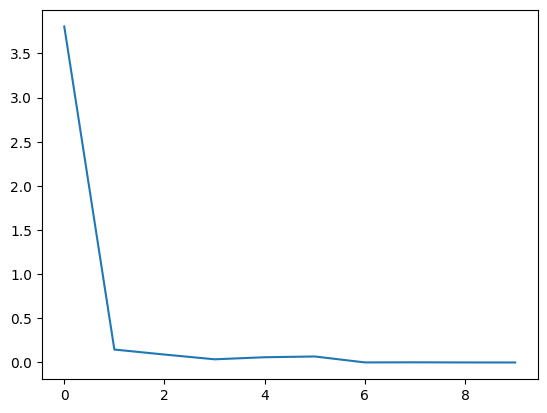

In [98]:
plt.plot(lossi)  # plot losses

In [99]:
get_performance(X_test.T, Y_test)  # final test accuracy

0.9688095238095238

layer 1 (      ReLU): mean +0.74, std 1.26, saturated: 26.85%
layer 3 (      ReLU): mean +3.46, std 3.23, saturated: 70.73%


Text(0.5, 1.0, 'activation distribution')

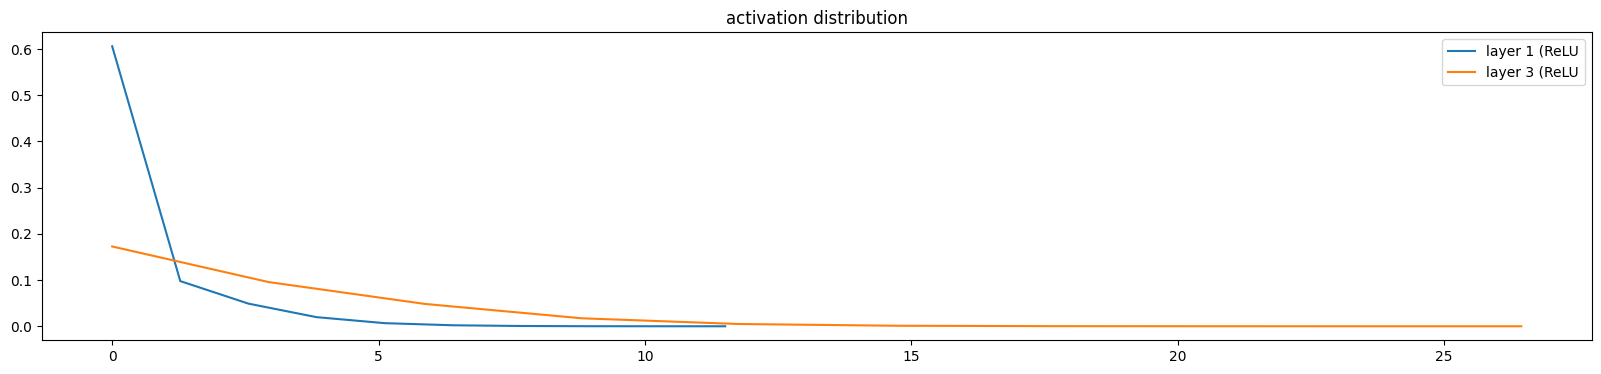

In [100]:
plt.figure(figsize=(20, 4)) # plot activations to check neuron saturation
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, ReLU):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.97).mean()*100))
    hy, hx = np.histogram(t, density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [102]:
test = pd.read_csv("test.csv").to_numpy()

for layer in layers:
    test = layer(test)
test = get_predictions(test)  # get test predictions

In [103]:
predictions = pd.DataFrame(test)
predictions = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions[0]})
predictions.to_csv("submission.csv", index=False) # store test predictions into csv file